## Assignment 1


Tasks:  
1. Try to improve the inversion result by applying a slight smoothing to the gradient. 
2. Apply the inversion using different initial model (i.e. different smoothing) and observe the convergence.   
3. Apply a heavy smoothing to the initial model (maybe double the smoothing in the original notebook), then impliment FWI with and without filtering out frequencies below 7 Hz and observe the difference 

For each of the above tasks, explain your observation and the reason for the convergence behavior.  

You can submit your answers in a normal pdf report or using the jupyter notebook in a pdf format but you have to answer the question using Markdown mode.   


In [1]:
import time
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from scipy import signal
%matplotlib inline

## setting the parameters 

In [2]:
device = torch.device('cuda:0')


# Load the true model for forward modelling 
path = './'
velocity_file= path + 'Marm.bin' # true model 

# Define the model and achuisition parameters
par = {'nx':601,   'dx':0.015, 'ox':0,
       'nz':221,   'dz':0.015, 'oz':0,
       'ns':30,    'ds':0.3,   'osou':0,  'sz':0,
       'nr':300,   'dr':0.03,  'orec':0, 'rz':0,
       'nt':4000,  'dt':0.001,  'ot':0,
       'freq':15,
       'num_batches':10, # increase thus number if you have a CUDA out of memory error 
        'FWI_itr': 100
      }

# Mapping the par dictionary to variables 
for k in par:
    locals()[k] = par[k]
    
fs = 1/dt # sampling frequency


# Don't change the below two lines 
num_sources_per_shot=1
num_dims = 2 



## The acquisition set-up

 Create arrays containing the source and receiver locations
 
    x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions].
    
    x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]

In [3]:

x_s = torch.zeros(ns, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(ns).float() * ds  
x_s[:, 0, 0] = sz

x_r = torch.zeros(ns, nr, num_dims)
x_r[0, :, 1] = torch.arange(nr).float() * dr
x_r[:, :, 1] = x_r[0, :, 1].repeat(ns, 1)
x_r[:, :, 0] = rz





## Create source wavelet
    [nt, num_shots, num_sources_per_shot]

I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you can use any function to create the wavelet but it needs to be converted to tensor. 

torch.Size([4000, 30, 1])


Text(0.5, 0, 'Time (s)')

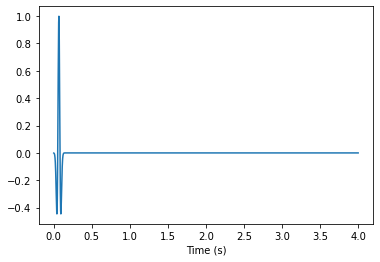

In [4]:


source_wavelet = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, ns, num_sources_per_shot))
print(source_wavelet.shape)


plt.plot(np.arange(0,nt)*dt,source_wavelet[:,0,0])
plt.xlabel('Time (s)')

### Load the velocity model 
Note: We often do not update the water layer, thus we will keep it untouched by masking the gradient in this region. 

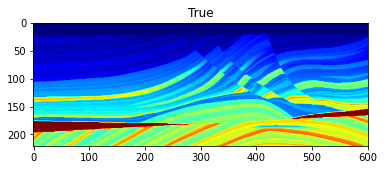

In [5]:
# function to get water layer mask
def mask(m):
    water_velocity= 1.5 # km/s
    msk = np.ones_like(m) 
    for i in range(m.shape[0]):
        for j in range (m.shape[1]): 
            msk[i,j] = (0 if m[i,j] <= water_velocity else 1)    
    return msk 


# Load the true model
model_true = (np.fromfile(velocity_file, np.float32)
              .reshape(nz, nx))

msk = mask(model_true) # get the mask for the water layer 

model_true = torch.Tensor(model_true) 
msk = torch.Tensor(msk)



m_vmin, m_vmax = np.percentile(model_true.numpy(), [2,98]) 
plt.imshow(model_true, vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('True');

## Forward modeling 

In [6]:
# Create 'true' data
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx) # create a propegator 

data_true = prop(source_wavelet.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

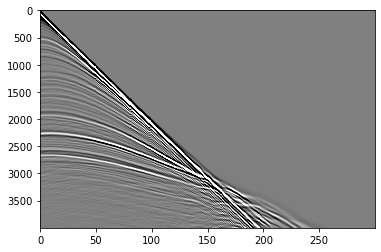

In [7]:
# Plot one shot gather
d_vmin, d_vmax = np.percentile(data_true[:,0].cpu().numpy(), [2,98])

plt.imshow(data_true[:,0,].cpu().numpy(), aspect='auto',
           vmin=-d_vmax, vmax=d_vmax,cmap='gray')



## Create initial model for FWI 



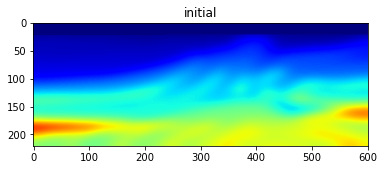

In [8]:
# Create initial guess model for inversion by smoothing the true model
model_init = gaussian_filter(model_true.cpu().detach().numpy(),
                                           sigma=[10,15])

model_init = torch.Tensor(model_init) 
model_init = model_init * msk  # to preserve the water layer  
model_init[model_init==0] = 1.5 # km/s


# Make a copy so at the end we can see how far we came from the initial model
model = model_init.clone()
model = model.to(device)
model.requires_grad = True

# plot the initial model 
plt.imshow(model_init, vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('initial');

##  Set the optimizer and the criterion 


In [9]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam([{'params': [model], 'lr': 0.01}])

## Filter the low frequencies from the observed data/wavelet   
####  Filter frequency below 7Hz and see how this affects the convergence. You may want to test this with different initial model like in the previous task 
(hint: you can use the below functions to filter the data or whatever function you want).

In [10]:

# def highpass_filter(freq, wavelet, dt):
#     """
#     Filter out low frequency

#     Parameters
#     ----------
#     freq : :obj:`int`
#     Cut-off frequency
#     wavelet : :obj:`torch.Tensor`
#     Tensor of wavelet
#     dt : :obj:`float32`
#     Time sampling
#     Returns
#     -------
#     : :obj:`torch.Tensor`
#     Tensor of highpass frequency wavelet
#     """

#     sos = signal.butter(4,  6/fs + freq / (0.5 * (1 / dt)), 'hp', output='sos') # AA: Added 6/fs to prevent frequency leak.
#     return torch.tensor( signal.sosfiltfilt(sos, wavelet,axis=0).copy(),dtype=torch.float32)




In [11]:
# Plot the spectrum 

##

## Main inversion loop 

Epoch: 0 Loss:  4.864205250339117e-13


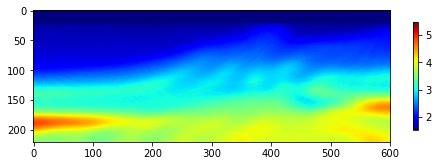

Epoch: 1 Loss:  4.493704907693793e-13
Epoch: 2 Loss:  4.221164569143468e-13
Epoch: 3 Loss:  4.031233795398232e-13
Epoch: 4 Loss:  3.8927057242768917e-13
Epoch: 5 Loss:  3.784011678217153e-13
Epoch: 6 Loss:  3.70110155224106e-13
Epoch: 7 Loss:  3.644418869740455e-13
Epoch: 8 Loss:  3.609853301694832e-13
Epoch: 9 Loss:  3.5883634828999273e-13
Epoch: 10 Loss:  3.5728251547616566e-13


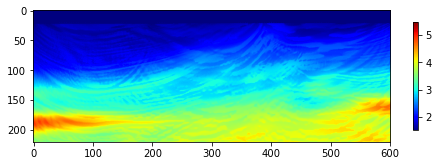

Epoch: 11 Loss:  3.5592079820510533e-13
Epoch: 12 Loss:  3.5451275670215967e-13
Epoch: 13 Loss:  3.529882532511642e-13
Epoch: 14 Loss:  3.512793541156833e-13
Epoch: 15 Loss:  3.494436660064597e-13
Epoch: 16 Loss:  3.4756519765120203e-13
Epoch: 17 Loss:  3.457279603187179e-13
Epoch: 18 Loss:  3.440363110092078e-13
Epoch: 19 Loss:  3.4248786193679347e-13
Epoch: 20 Loss:  3.411057108429136e-13


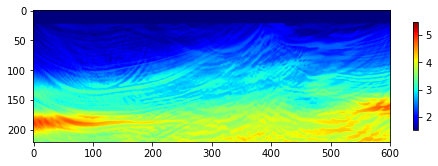

Epoch: 21 Loss:  3.3985121015528376e-13
Epoch: 22 Loss:  3.386880043727749e-13
Epoch: 23 Loss:  3.375088963937143e-13
Epoch: 24 Loss:  3.363290828362086e-13
Epoch: 25 Loss:  3.351798412388682e-13
Epoch: 26 Loss:  3.3399861398337354e-13
Epoch: 27 Loss:  3.3280317351502397e-13
Epoch: 28 Loss:  3.3158100407499084e-13
Epoch: 29 Loss:  3.3040845128390903e-13
Epoch: 30 Loss:  3.292399295226232e-13


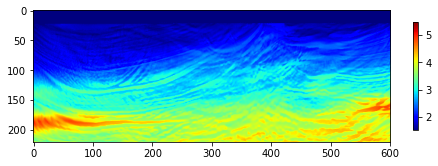

Epoch: 31 Loss:  3.2806969336665213e-13
Epoch: 32 Loss:  3.269150129707574e-13
Epoch: 33 Loss:  3.258078578994672e-13
Epoch: 34 Loss:  3.2475055664635353e-13
Epoch: 35 Loss:  3.2372879731922314e-13
Epoch: 36 Loss:  3.2274477923912356e-13
Epoch: 37 Loss:  3.2174905304611055e-13
Epoch: 38 Loss:  3.2066978907570754e-13
Epoch: 39 Loss:  3.1954308024882997e-13
Epoch: 40 Loss:  3.1845555770719123e-13


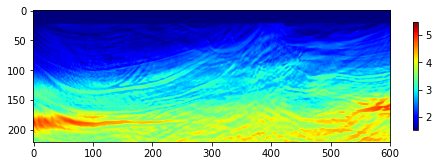

Epoch: 41 Loss:  3.1745818699971113e-13
Epoch: 42 Loss:  3.1655617144978466e-13
Epoch: 43 Loss:  3.157259173781825e-13
Epoch: 44 Loss:  3.1493052294752463e-13
Epoch: 45 Loss:  3.141163641959862e-13
Epoch: 46 Loss:  3.132814832069097e-13
Epoch: 47 Loss:  3.1246252050801094e-13
Epoch: 48 Loss:  3.1166442488928425e-13
Epoch: 49 Loss:  3.109047782136158e-13
Epoch: 50 Loss:  3.101809627256821e-13


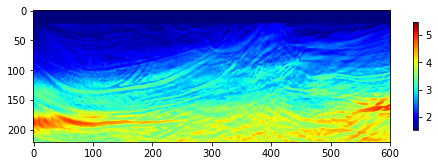

Epoch: 51 Loss:  3.094949888581835e-13
Epoch: 52 Loss:  3.0884401566261483e-13
Epoch: 53 Loss:  3.0822102504749166e-13
Epoch: 54 Loss:  3.076204973226132e-13
Epoch: 55 Loss:  3.07032515426233e-13
Epoch: 56 Loss:  3.064390464504205e-13
Epoch: 57 Loss:  3.058504407142746e-13
Epoch: 58 Loss:  3.052838620699221e-13
Epoch: 59 Loss:  3.047384253679331e-13
Epoch: 60 Loss:  3.042013272817933e-13


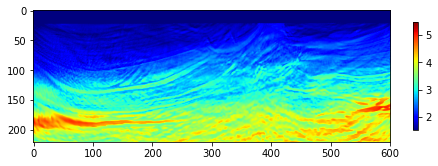

Epoch: 61 Loss:  3.036853639382369e-13
Epoch: 62 Loss:  3.031622368135291e-13
Epoch: 63 Loss:  3.0265206294016723e-13
Epoch: 64 Loss:  3.021105543534711e-13
Epoch: 65 Loss:  3.015211104782239e-13
Epoch: 66 Loss:  3.0092941688346884e-13
Epoch: 67 Loss:  3.00328084053774e-13
Epoch: 68 Loss:  2.997298170598318e-13
Epoch: 69 Loss:  2.991472565978305e-13
Epoch: 70 Loss:  2.985806563541378e-13


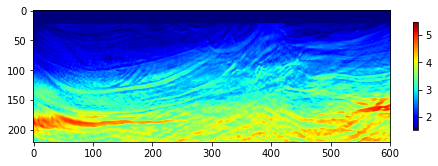

Epoch: 71 Loss:  2.9802802410726185e-13
Epoch: 72 Loss:  2.9748577902541807e-13
Epoch: 73 Loss:  2.9694701567250397e-13
Epoch: 74 Loss:  2.963990800115623e-13
Epoch: 75 Loss:  2.9586492112974947e-13
Epoch: 76 Loss:  2.953338935169844e-13
Epoch: 77 Loss:  2.9481651478137317e-13
Epoch: 78 Loss:  2.9431936086320176e-13
Epoch: 79 Loss:  2.9382668690228837e-13
Epoch: 80 Loss:  2.933324594829497e-13


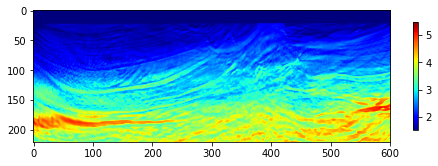

Epoch: 81 Loss:  2.928585165968737e-13
Epoch: 82 Loss:  2.924013415750215e-13
Epoch: 83 Loss:  2.9196315364371495e-13
Epoch: 84 Loss:  2.915469919571688e-13
Epoch: 85 Loss:  2.9111242678577767e-13
Epoch: 86 Loss:  2.9066153823070176e-13
Epoch: 87 Loss:  2.902256199241774e-13
Epoch: 88 Loss:  2.897865233382767e-13
Epoch: 89 Loss:  2.893589525414475e-13
Epoch: 90 Loss:  2.889372489300857e-13


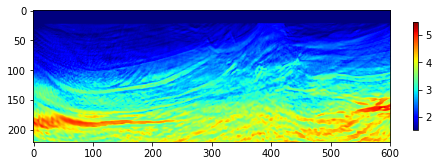

Epoch: 91 Loss:  2.8851387391096075e-13
Epoch: 92 Loss:  2.8809487381700836e-13
Epoch: 93 Loss:  2.8767251777851895e-13
Epoch: 94 Loss:  2.872600392029857e-13
Epoch: 95 Loss:  2.8684725463680027e-13
Epoch: 96 Loss:  2.8643261040977913e-13
Epoch: 97 Loss:  2.860278449162636e-13
Epoch: 98 Loss:  2.8561704198365825e-13
Epoch: 99 Loss:  2.8521478180184245e-13
Runtime: 6.750570611159007 minutes


In [12]:
# Iterative inversion loop
num_shots_per_batch = int(ns / num_batches)
msk = msk.to(device)
epoch_loss = []
updates = []
gradients = []



t_start = time.time()
for epoch in range(FWI_itr):
  running_loss=0
  for it in range(num_batches):
    optimizer.zero_grad()
    prop = deepwave.scalar.Propagator({'vp': model}, dx)
    batch_src_wvl = source_wavelet[:,it::num_batches,].to(device)
    batch_data_true = data_true[:,it::num_batches].to(device)
    batch_x_s = x_s[it::num_batches].to(device)
    batch_x_r = x_r[it::num_batches].to(device)
    data_pred = prop(batch_src_wvl, batch_x_s, batch_x_r, dt)
    loss = criterion(data_pred, batch_data_true)
    running_loss += loss.item()
    loss.backward()
  epoch_loss.append(running_loss)     

  # Apply some operations to the gradient
  if epoch==0: gmax = torch.abs(model.grad).max()
  model.grad = model.grad / gmax  * msk  # normalizing by the first gradient and mask the wter layer
    

  # update the model 
  optimizer.step()
  print('Epoch:', epoch, 'Loss: ', running_loss)

  # save the model updates and gradients for each iteration
  updates.append(model.detach().clone().cpu().numpy())
  gradients.append(model.grad.cpu().detach().numpy())  
    
  # plotting every 10 itr   
  if epoch % 10 == 0:
    plt.figure(figsize=(8, 4))
    plt.imshow(model.cpu().detach().numpy(), vmin=m_vmin, vmax=m_vmax,
               cmap='jet')
    plt.colorbar(shrink=0.5)
    plt.show()   
#     plt.figure(figsize=(8, 4))
#     gr = model.grad.cpu().detach().numpy()
#     g_min, g_max = np.percentile(gr, [2,98]) 
#     plt.imshow(gr, cmap='bwr',vmin=-g_max,vmax=g_max)
#     plt.colorbar(shrink=0.5)
#     plt.show()
    
t_end = time.time()
print('Runtime:', (t_end - t_start)/60 ,'minutes')

## Plot the convergence curve and the final inversion results 

In [13]:
updates = np.array(updates)
gradients = np.array(gradients)
obj = np.array(epoch_loss)


Text(0.5, 0, 'iteration#')

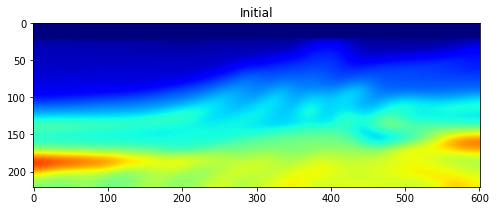

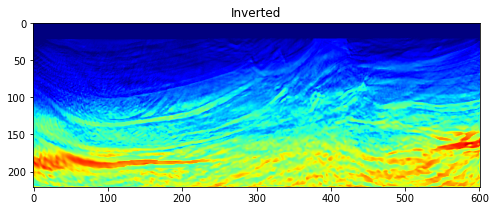

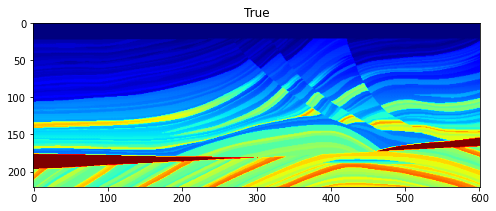

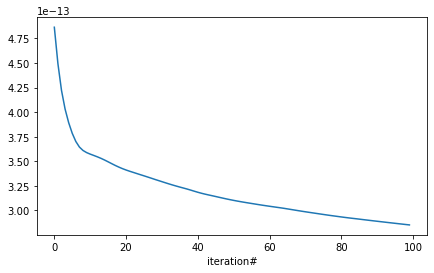

In [14]:
# Plot initial, inverted, and true models
figsize = (8, 4)
plt.figure(figsize=figsize)
plt.imshow(model_init.numpy(), vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('Initial');
plt.figure(figsize=figsize)
plt.imshow(updates[-1], vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('Inverted');
plt.savefig('Inverted_model')
plt.figure(figsize=figsize)
plt.imshow(model_true.numpy(), vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('True');
plt.savefig('True_model')



plt.figure(figsize=(7,4))
plt.plot(np.arange(FWI_itr),obj)
plt.xlabel('iteration#')